In [322]:
using PyPlot

In [323]:
include("../src/model.jl");
include("../src/diagnostics.jl");
include("../src/optimize.jl");
include("../src/plotting.jl");

## Model setup

#### Physical parameters

In [324]:
# Model domain
dt = 10.
t = Array(2020:dt:2200);

# "Best-guess equilibrium climate sensitivity"
ECS = 3.0;

#### Economic parameters

Assume damages of 2% of global world product (GWP) for 3$^{\circ}$C of warming (similar to DICE damage function).

In [325]:
GWP = 100. # global world product (trillion $ / year)

β = 0.02*GWP/(3.0)^2 # damages (trillion USD / year / celsius^2)
utility_discount_rate = 0.025 # ρ (relative low value from Stern review)

# Control technology cost scales (for full deployment, α=1.)
reduce_cost = 0.01*GWP;
remove_cost = 0.02*GWP;
geoeng_cost = 0.05*GWP;
adapt_cost = 0.03*GWP;

In [326]:
baseline_emissions_scenario = baseline_emissions(t, 5., 2060., 40.)

economics = Economics(
    β, utility_discount_rate,
    reduce_cost, remove_cost, geoeng_cost, adapt_cost,
    0., 0., 0., 0., # Assumed initial condition of no deployments in 2020
    baseline_emissions_scenario
);

### Initialize model

In [327]:
ensemble = Dict{String, ClimateModel}();

name = "Example configuration";
present_year = 2020.

# Arbitrary initial guess of climate control policies,
# to be optimized later!
controls = init_zero_controls(t);

# Create instance of idealized integrated assessment climate model
model = ClimateModel(name, ECS, t, dt, controls, economics, present_year);

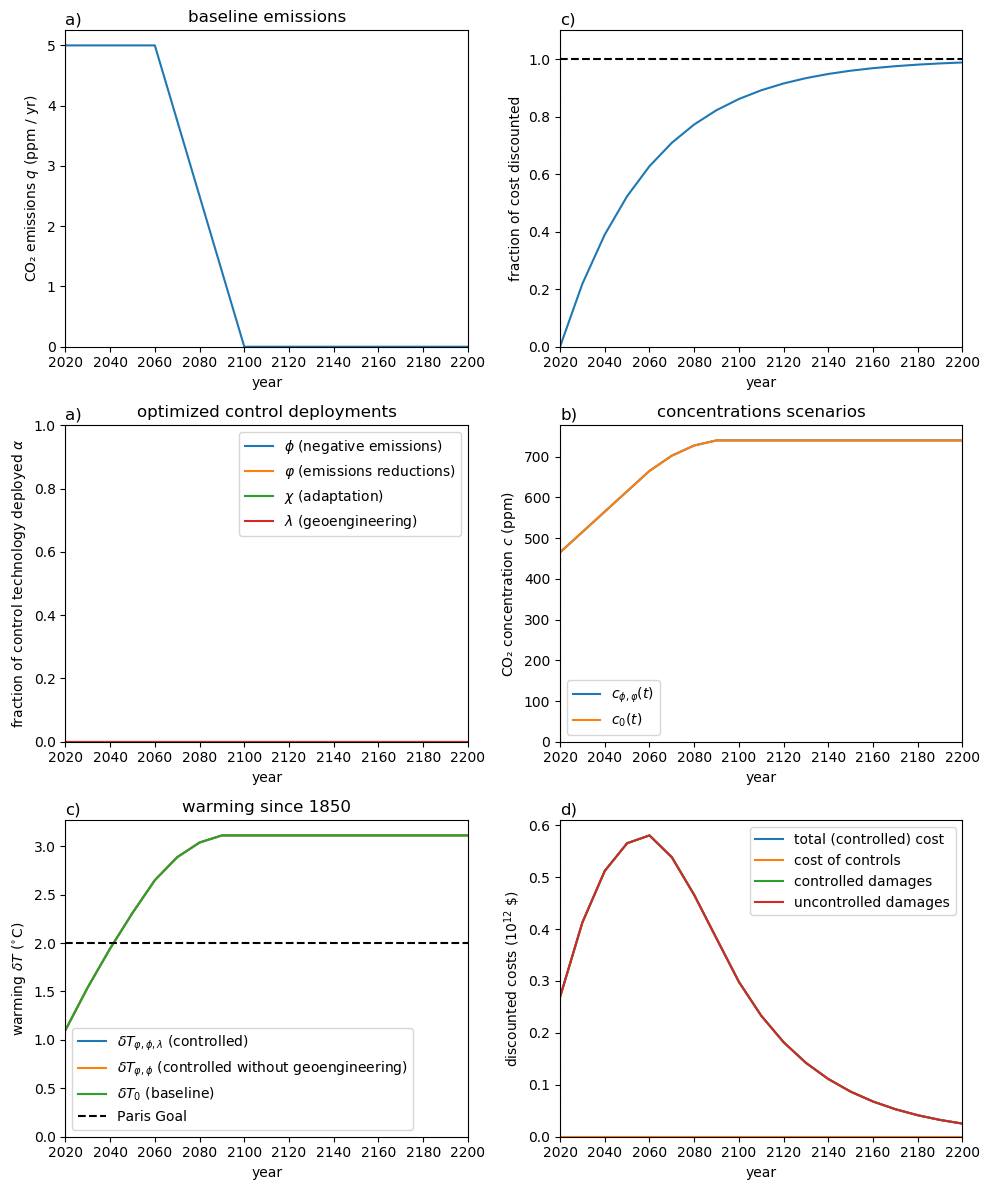

In [328]:
plot_state(model)

In [329]:
print(string(
        "Social cost of carbon: \$",
        SCC(model),"."))

Social cost of carbon: $23.8.

## Model optimization

In [330]:
# optimize model for lowest total (cumulative discounted) net (damages + controls) cost.
maxslope = 1. / 60.
@time optimize!(model, tolerance=1.e-7, maxslope=maxslope)
ensemble[model.name] = model;

Converged after 5001 iterations.  24.534288 seconds (178.68 M allocations: 34.680 GiB, 14.59% gc time)


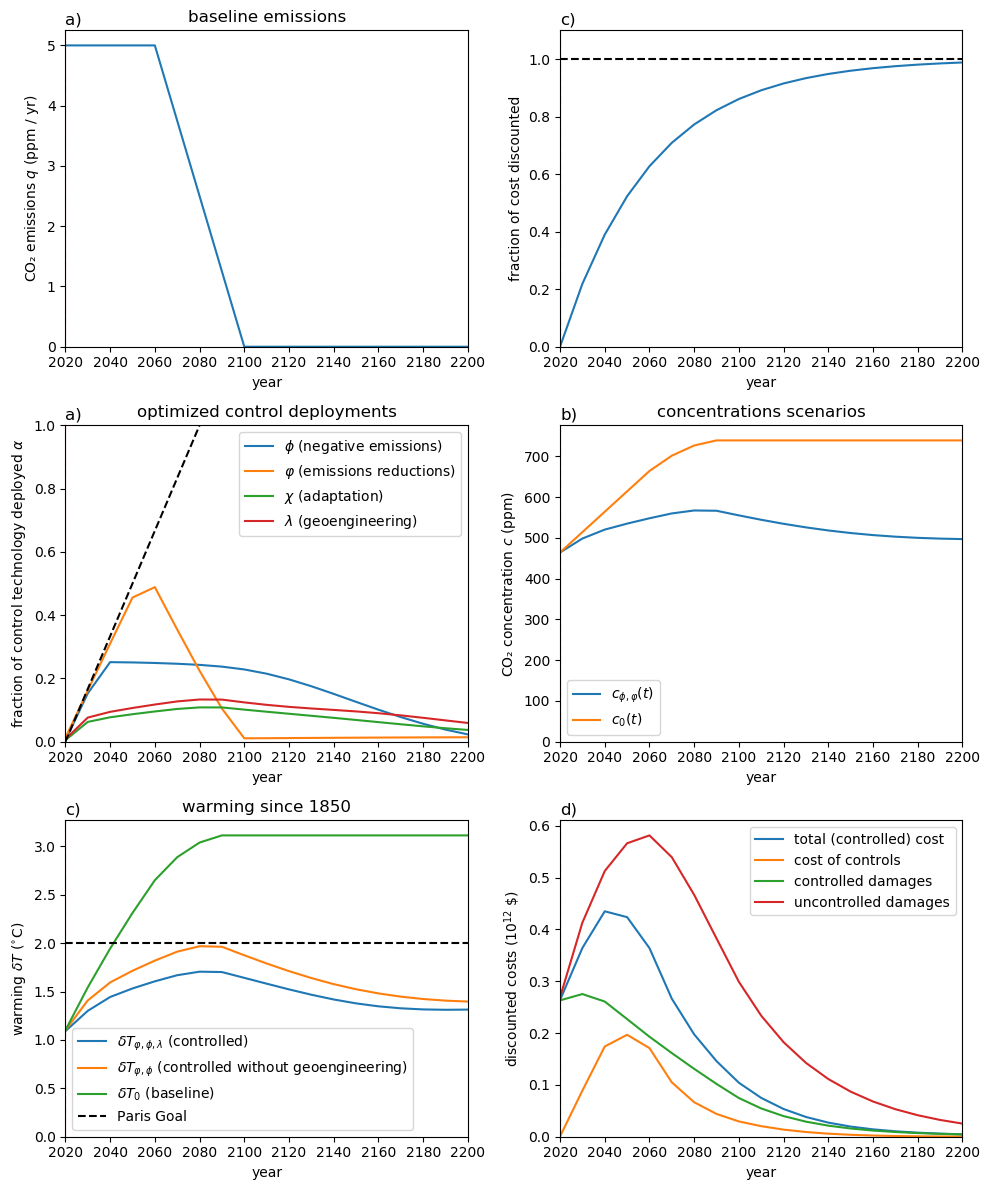

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x15743a550>

In [331]:
# plot optimized model state
plot_state(model)
subplot(3,2,3)
plot([2020., 2020. + 1. /maxslope], [0.,1.], "k--")

In [332]:
print(string(
        "Social cost of carbon: \$",
        SCC(model),"."))

Social cost of carbon: $16.12.